# Twiss

This is an example of plotting lines and twiss results.
First, create a simple line and a tracker:

In [1]:
%load_ext autoreload
%autoreload 2

import xtrack as xt
import xdeps as xd
import xpart as xp
import xplt
import numpy as np

xplt.apply_style()

In [2]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [
        xt.Node(0.7, "QF"),
        xt.Node(1.4, "MU"),
        xt.Node(2.1, "QD"),
        xt.Node(2.8, "MU"),
    ],
    "b": [
        xt.Node(2.2, "MU"),
        xt.Node(2.9, "QD"),
        xt.Node(3.6, "MU"),
        xt.Node(4.3, "QF"),
    ],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

# sextupoles
for i in range(n):
    sx = xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))])
    nodes.append(xt.Node(0.2, sx, from_=f"S{i+1}", name=f"S{i+1}SX"))

# apertures
nodes.append(xt.Node(5, xt.LimitRect(min_x=-5e-3, max_x=3e-3, max_y=3e-3)))
nodes.append(xt.Node(10, xt.LimitRectEllipse(max_x=6e-3, max_y=1)))

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line.particle_ref = xp.Particles()
line.build_tracker();

Then determine it's twiss parameters. Use the `at_s` parameter to get the twiss data with high resolution as a function of s (rather than at each element only).

In [3]:
tw = line.twiss(
    method="4d", at_s=np.linspace(0, line.get_length(), 500, endpoint=False)
)

Slicing line: 100%|███████████████████████████████████████████████████████| 74/74 [00:00<00:00, 7698.64it/s]


## Default twiss plot

Create a default {class}`TwissPlot <xplt.twiss.TwissPlot>` (passing `line` to the plot adds a [beamline plot](/examples/line.ipynb#multipole-strength) to the top):

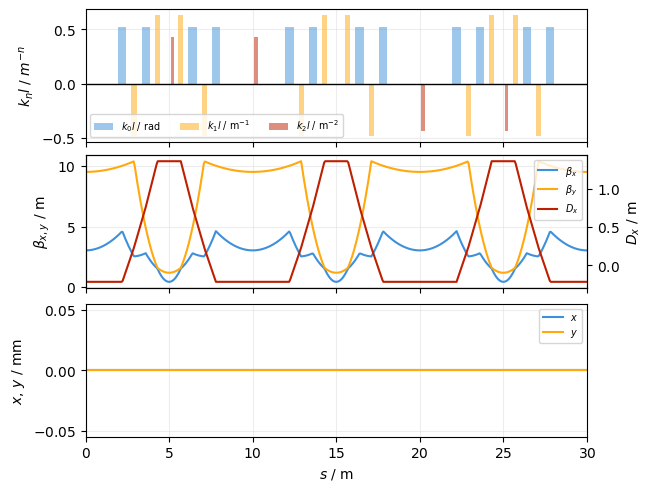

In [4]:
plot = xplt.TwissPlot(tw, line=line)

## Beam size plot

You can also plot the beam size and envelope:

In [5]:
# Normalized emittance in m*rad
cv = tw.get_betatron_sigmas(nemitt_x=1e-6, nemitt_y=1e-6)

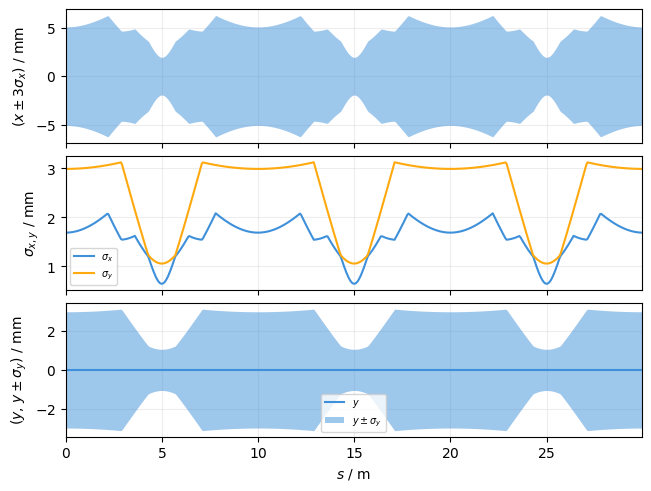

In [6]:
plot = xplt.TwissPlot((tw, cv), "envelope3_x, sigma, y + envelope_y")

## Apertures

You can also plot apertures onto the existing plot:

In [7]:
ap = xplt.util.apertures(line)
xd.Table(ap, index="s").to_pandas()

,s,min_x,max_x,min_y,max_y
0,5.0,-0.005,0.003,-1.000000e+10,0.003
1,10.0,-0.006,0.006,-1.000000e+00,1.000


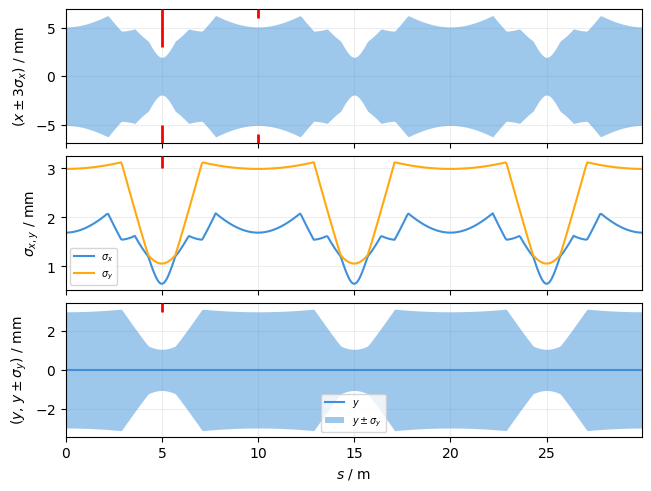

In [8]:
plot.plot_apertures(ap, lw=2, color="r")
plot.fig

## Customisation

Use the parameter `kind` to specify what is plotted. This is a string specifying the properties to be plotted, separated by `,` for each subplot. Use `a+b` to plot multiple properties on an axis and `a-b` to separate left and right axis. See {class}`TwissPlot <xplt.twiss.TwissPlot>` for details.

A list with all supported properties can be found in {doc}`/examples/concepts` under *Default properties* and *Twiss plot*.

```{tip}
Use prefix notation as shorthand to plot both x- and y-properties, e.g. `bet` for `betx+bety`
```

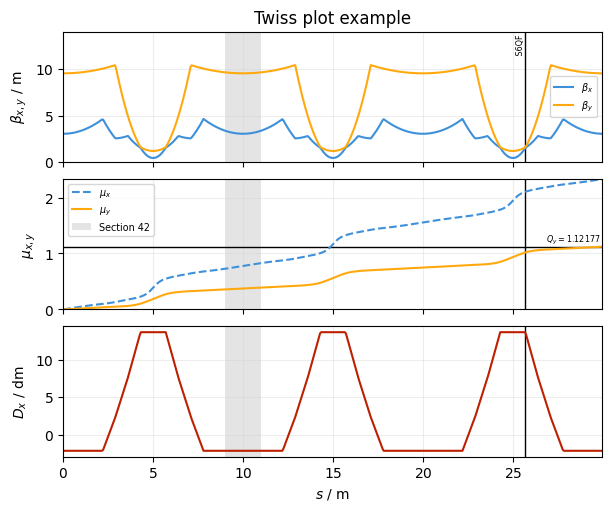

In [9]:
plot = xplt.TwissPlot(
    tw,
    kind="bet,mux+muy,dx",  # 3 subplots: plot beta functions ("bet"="betx+bety") on the first,
    #                                     phase advances on the second, and dispersion on the third
    display_units=dict(d="dm"),  # dispersion in deci-meter ("d=" for "dx" and "dy")
    figsize=(6, 5),
)

# add some annotations
plot.axline("s", line.get_s_position("S6QF"), annotation="S6QF")
plot.axspan("s", 9, 11, label="Section 42")
plot.axline("muy", tw.qy, annotation=f"$Q_y={tw.qy:g}$", annotation_loc=1)

# adjust some axes
plot.axis(0).set(title="Twiss plot example", ylim=(0, 14))
plot.axis("mux").set(ylim=(0, tw.qx))

# adjust line layout
plot.artist("mux").set(ls="--")
plot.artist(subplot=2).set(c="pet2")

# legend is shown by default for subplots with more than 1 trace
plot.legend(1, loc="upper left")  # call it manually to reflect updated line layout
# plot.legend() # uncomment this to show legends on all subplots

-----------------
```{seealso}
- {class}`xplt.twiss`
```